# Assignment 10

#### ``Objectives``
1. Implement a CNN to detect diabetic retinopathy (DR) from retina images taken using fundus photography under a variety of imaging conditions.
2. Improve generalization performance and reduce overfitting using **image transformation** and **data augmentation** techniques.

#### ``Motivation``

Diabetic retinopathy (DR) is an eye condition that  affects blood vessels in the retina. It can cause vision loss and blindness in people who have diabetes. Screening for DR allows earlier and more effective treatment options for millions of people.

#### ``Data``

In this assignment you will use a small dataset of retina images (`Download` links: [images](https://drive.google.com/drive/folders/1sdfUC64Un1iwuiHEehcbijxB54OhU_nd?usp=sharing) and [labels](https://drive.google.com/drive/folders/1MOlSJBZg7L1HtG5vHPt77ighRvQaGfDg?usp=sharing)). You will **build** and **train** a **CNN model** to predict whether or not to refer a patient for DR treatment using binarized severity of DR in patients: no referral if {No DR, mild} and referral if {moderate, severe, and proliferate DR}.


<u>Note</u>: the original dataset is hosted by Kaggle [[Source]](https://www.kaggle.com/c/aptos2019-blindness-detection/).

Import the necessary libraries and make sure to replace IMAGE_PATH and LABEL_PATH with the path to the directories where you saved the data.

---
### Step 1: Import libraries

In [ ]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

# sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# plots
import seaborn as sns
import matplotlib.pyplot as plt

random.seed(2)
%matplotlib inline

# import from google drive
from google.colab import drive
drive.mount('/content/drive')
IMAGE_PATH = '/content/drive/My Drive/Datasci207/DiabeticRetinopathy/images/' # replace with your path
LABEL_PATH = '/content/drive/My Drive/Datasci207/DiabeticRetinopathy/labels/' # replace with your path

Mounted at /content/drive


At this point, you may ask yourself what the best model that fits this data is. First, you will want to read through the data description in Kaggle (see the link to the original dataset above). Understanding what you are working with challenges you to write preprocessing code that uncovers your data's most helpful information.

---
#### <span style="color:chocolate"> Exercise 1 (10 points) </span>

Read the data description from Kaggle and list (a) the source of images and (b) the labeling procedure.

*Written answer*:

(a) The images are taken using fundus photography (photographing the rear of the eye) under a variety of imaging conditions. Thhe images were gathered from multiple clinics using a variety of cameras over an extended period of time.

(b) The images are labeled (by physicians) based on severity of diabetic retinopathy on a scale of 0 to 4, the convention being 0=No DR, 1=Mild, 2=Moderate, 3=Severe, 4=Proliferative DR.

---
### Step 2: Data ingestion

Let's load the 2D images and their corresponding labels.

``labels``

In [ ]:
labels = pd.read_csv(
    LABEL_PATH + 'labels.csv'
)

print('Shape of labels:', labels.shape)
print('Unique diagnosis codes:', np.sort(labels.diagnosis.unique()))
labels.head()

Shape of labels: (200, 2)
Unique diagnosis codes: [0 1 2 3 4]


,id_code,diagnosis
0,000c1434d8d7,2
1,0024cdab0c1e,1
2,0083ee8054ee,4
3,00a8624548a9,2
4,00b74780d31d,2


There are 200 training images corrresponding to 5 different diabetic retinopathy (DR) diagnosis codes:

* No DR (0)
* mild (1)
* moderate (2)
* severe (3)
* proliferate DR (4)


``images``

In [ ]:
images = []

for idx, img in enumerate(os.listdir(IMAGE_PATH)):
    img = load_img(
    IMAGE_PATH + img)
    images.append(img)

---
### Step 3: Exploratory Data Analysis (EDA)

#### <span style="color:chocolate"> Exercise 2 (10 points) </span>

Plot a histogram for the five classes of DR. Are the classes balanced?


Note: It's acceptable to plot the distribution of classes before splitting your data into training, validation, and test sets. Doing so does not compromise the "blindness" of the test data. Why?

Text(0, 0.5, 'Frequency')

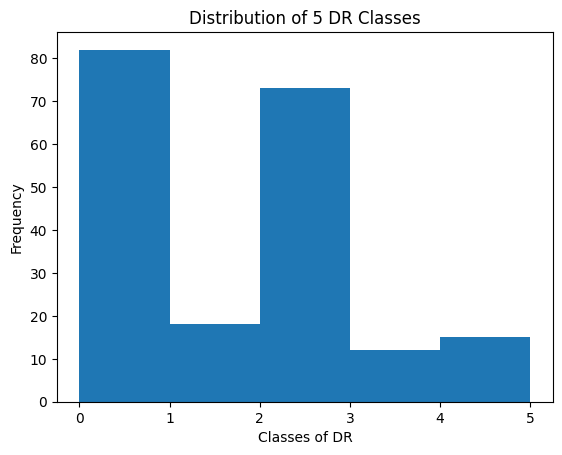

In [ ]:
#plot histogram
plt.hist(labels.diagnosis, bins=[0,1,2,3,4,5])
plt.title("Distribution of 5 DR Classes")
plt.xlabel("Classes of DR")
plt.ylabel("Frequency")


Comment on class balance: The classes are not balanced. There are the most 0 labels (80) and the least 1 labels (about 10). There are about 8 times as many 0s as 1s. Also, there are 70 2 labels, which is a lot more than the other labels (1 and 4 at about 20 each). There is no balance.

#### <span style="color:chocolate"> Exercise 3 (10 points) </span>

Print 8 images from the data. What can you say about the size, focus/orientation of these images?

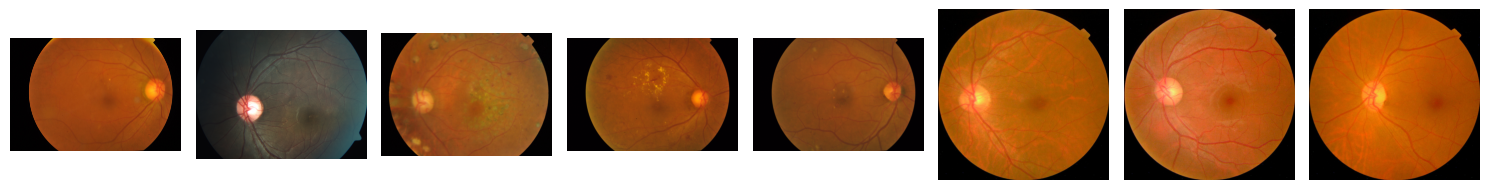

In [ ]:
#printing 8 images

fig, axes = plt.subplots(1, 8, figsize=(15,3))

for i in range (8):
  axes[i].imshow(images[i])
  axes[i].axis('off')

plt.tight_layout()
plt.show()

Comment on the size, focus/orientation of the 8 images: The 8 images appear to have starkly different orientations and focus levels. Some of the pictures appear to be mirrored. Some are more exposed to light and some are less, and some are more blurry than others. The sizes also differ, with the last three images that were printed being significantly bigger than the other five.

---
### Step 4: Data preprocessing

First, we will correct for class imbalance. Note that imbalanced data is common in healthcare, and it happens because some diseases are rare. The presence of imbalanced data hampers the detection of rare events as most classification methods implicitly assume a similar occurrence of classes and are designed to maximize the overall classification accuracy.

We will correct for class imbalance in two ways:

  * First, we will binarize the DR diagnosis as follows:
     - 'no refer' are {No DR, mild}
     - 'refer' are {Moderate, Severe, Proliferate}


  * Second, we'll only take 80 random samples from the 'no refer' class and 80 from the 'refer' class.

It is a crude method to deal with imbalanced data, but it will be good enough for this homework.

In [ ]:
np.random.seed(1234)

no_refer = labels[labels.diagnosis.isin((0,1))]
refer = labels[labels.diagnosis.isin((2,3,4))]

# randomly draw 80 images from each classes
temp_no_refer = list(np.random.choice(
    no_refer.id_code,
    size=80,
    replace=False
))

temp_refer = list(np.random.choice(
    refer.id_code,
    size=80,
    replace=False
))

Next, we will use the ``preprocess_data_part1()`` function defined below to generate lists of images and labels (images_mini and y_mini) based on the values in the temp_no_refer and temp_refer lists. Note that the size of the image is set to (224, 224).

In [ ]:
def preprocess_data_part1(IMAGE_PATH, LABEL_PATH, temp_no_refer, temp_refer):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists

    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    LABEL_PATH (str): path to directory with labels.
    temp_no_refer (str): list of labels for the no refer category
    temp_refer (str): list of labels for the refer category

    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 224, 224, 3)
    y_mini (np.ndarray): Labels of shape (N,)
    """
    y_mini = []
    images_mini = []

    # create lists of images and labels `images_mini` and `y_mini`
    # based on temp_no_refer and temp_refer selections
    for idx, img in enumerate(os.listdir(IMAGE_PATH)):
        # read labels
        if img.split('.')[0] in temp_no_refer:
                y_mini.append(0)
        elif img.split('.')[0] in temp_refer:
                y_mini.append(1)
        else:
            continue


        # read image
        img = load_img(
            IMAGE_PATH + img,
            target_size=(224, 224)
        )

        # transform image to array
        img = img_to_array(img)

        # append to images
        images_mini.append(img)

    # stack images and trasnform to array
    images_mini = np.stack(images_mini)
    y_mini = np.array(y_mini).flatten()

    return images_mini, y_mini

In [ ]:
# generate images and labels based on preprocess_data_part1() function
images_mini, y_mini = preprocess_data_part1(
    IMAGE_PATH, LABEL_PATH, temp_no_refer, temp_refer
)

print(f"images_mini shape {images_mini.shape}")
print(f"y_mini shape {y_mini.shape}")

images_mini shape (160, 224, 224, 3)
y_mini shape (160,)


#### <span style="color:chocolate"> Exercise 4 (20 points) </span>

Create train, validation, and test data. Implement the `preprocess_data_part2()` function according to the following guidelines:

1. shuffle images and labels before splitting the data

2. use a (0.6,0.2,0.2)train/validation/test set split

3. perform image transformation and augmentation, as follows:
    * Applied on training set only:
         - create additional copies (augmentations) of the training images by flipping left right each image (Hint: use the method available in the tf.image module).
         - concatenate the augmented images to the original training images. Note that the train set should be double in size after data augmentation, i.e., 192 images and labels.
    * Applied on training, validation, and test sets:
        - rescale images by dividing each pixel by 255.0

Reason for doing image augmentation: The quantity and diversity of data gathered significantly impact the results of a CNN model. One can use augmentations to artificially inflate the training dataset by warping the original data so that their label does not change. These augmentations can significantly improve learning results without collecting new data.

In [ ]:
from sklearn.model_selection import train_test_split

def preprocess_data_part2(images, labels, splits):
    """ Split data into train, validation and test sets; apply transformaions and augmentations

    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    labels (np.ndarray): Labels of shape (N,)
    splits (tuple): 3 values summing to 1 defining split of train, validation and test sets

    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)

    """

    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator
    tf.random.set_seed(1234)
    np.random.seed(1234)

    # shuffle data
    # reset in case run multiple times
    indices = np.arange(len(images))
    # reordering images and labels
    shuffled_indeces = np.random.permutation(indices)
    images = images[shuffled_indeces]
    labels = labels[shuffled_indeces]

    # create data splits (training, val, and test sets)
    X_temp, X_test, Y_temp, y_test = train_test_split(images, labels, test_size = split[2], random_state = 1234)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, Y_temp, test_size = split[1]/(split[0] + split[1]), random_state = 1234)

    # image augmentation (random flip) on training data
    X_train_augm = tf.image.random_flip_left_right(X_train)

    # concatenate original X_train and augmented X_train_augm data
    X_train = tf.concat([X_train, X_train_augm], axis = 0)

    # concatenate y_train (note the label is preserved)
    y_train_augm = y_train
    y_train = tf.concat([y_train, y_train_augm],axis=0)

    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle).numpy() # transform X back to numpy array instead of tensor
    y_train = tf.gather(y_train, shuffle).numpy() # transform y back to numpy array instead of tensor

    # rescale training, val, and test images by dividing each pixel by 255.0
    X_train = X_train / 255.0
    X_val = X_val / 255.0
    X_test = X_test / 255.0

    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
# define splits
split = (0.6, 0.2, 0.2)

X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini,
    y_mini,
    split
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (192, 224, 224, 3)
y_train shape (192,)
X_val shape (32, 224, 224, 3)
y_val shape (32,)
X_test shape (32, 224, 224, 3)
y_test shape (32,)


---
### Step 5: Modeling

#### <span style="color:chocolate"> Exercise 5 (20 points) </span>

The objective is to build and train a CNN model to refer patients to doctors based on the severity of DR seen in these images. You are interested in exploring binary classification of 'no refer' and 'refer'.

Implement a CNN classifier according to the following guidelines (let's call this *model_tf*):

1. Implement this model using the TF Keras API.
1. The model receives input images of size 224 x 224 x 3 (that is, the images have three color channels)
2. The input data goes through one convolutional layer that has the following specifications:
    - filters = 12
    - kernel_size = (4 x 4)
    - strides = (1, 1)
    - padding = 'same'
    - data_format = 'channels_last'
    - name = 'conv_1'
    - activation = 'relu'
3. The convolutional layer is followed by a max-pooling layer with pool_size = (2,2). Note: this will reduce the size of the feature maps.
4. The max-pooling layer is followed by a dropout layer with rate = 0.3.
5. The dropout layer is followed by a flattening layer.
6. The last layer of the model is the classification head.
7. Build and compile the model using the Adam optimizer and learning_rate = 0.1. Print summary of the model.
8. Train the model on (X_train, y_train) data for 20 epochs. Add early stopping (Hint: pass the early_stopping implementation below to the fit() method as "callbacks=[early_stopping]").
9. How many parameters does the model have?
10. Generate a plot (for the training and validation data) with the loss values on the y-axis and the epoch number on the x-axis for visualization. Make sure to include axes name and title. Hint: check what the tf.keras.Model.fit() method returns.
11. Evaluate the accuracy of the model on (X_train, y_train) and (X_val, y_val) data. Comment on model performance on training vs. validation datasets.

In [ ]:
# define an instance of the early_stopping class
early_stopping = tf.keras.callbacks.EarlyStopping(
monitor='accuracy',
verbose=1,
patience=5,
mode='max',
restore_best_weights=True)

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 224, 224, 12)   │           588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 112, 112, 12)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 112, 112, 12)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_29 (Flatten)            │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │       150,529 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,117 (590.30 KB)

 Trainable params: 151,117 (590.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 792ms/step - accuracy: 0.4320 - loss: 427.3914 - val_accuracy: 0.4688 - val_loss: 0.7001
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4664 - loss: 0.7018 - val_accuracy: 0.4688 - val_loss: 0.7042
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 761ms/step - accuracy: 0.4664 - loss: 0.7039 - val_accuracy: 0.4688 - val_loss: 0.6986
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 752ms/step - accuracy: 0.4664 - loss: 0.6979 - val_accuracy: 0.5312 - val_loss: 0.6930
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 967ms/step - accuracy: 0.5336 - loss: 0.6930 - val_accuracy: 0.5312 - val_loss: 0.6913
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 756ms/step - accuracy: 0.5336 - loss: 0.6914 - val_accuracy: 0.5312 - val_loss: 0.6913
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 950ms/step - accuracy: 0.5336 - loss: 0.6911 - val_accuracy: 0.5312 - val_loss: 0.6912
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 751ms/step - accuracy: 0.5336 - loss: 0.6909 - val_accuracy: 0.5312 - val_loss: 

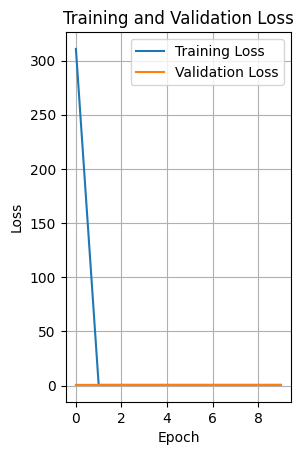

In [ ]:

tf.random.set_seed(1234)
np.random.seed(1234)

# initialize model
model_tf = tf.keras.Sequential()

# add convolutional layer
model_tf.add(tf.keras.layers.Conv2D(
    filters=12,
    kernel_size=(4, 4),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    activation='relu',
    name='conv_1'
))

# add max pooling layer
model_tf.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

# add dropout layer
model_tf.add(tf.keras.layers.Dropout(rate=0.3))

# add a flattening layer
model_tf.add(tf.keras.layers.Flatten())

# add the classification layer (doing binary because of loss given)
model_tf.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# build and compile model
model_tf.build(input_shape=(None, 224, 224, 3))
model_tf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# print model_tf summary
model_tf.summary()

# train model_tf on (X_train, y_train) data
history = model_tf.fit(x=X_train, y=y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[early_stopping])

# plot loss curves
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# evaluate the accuracy of model_tf on (X_train, y_train) and (X_val, y_val)
train_loss, train_accuracy = model_tf.evaluate(X_train, y_train)
val_loss, val_accuracy = model_tf.evaluate(X_val, y_val)

print("Train Accuracy: ", train_accuracy)
print("Val Accuracy: ", val_accuracy)

How many parameters does *model_tf* have? 151,117 parameters

Comment on *model_tf* accuracy on training vs. validation data:

Train Accuracy:  0.5208333134651184; Val Accuracy:  0.53125

The training and validation accuracies are somewhat similar, which indicates that the model generalizes well. However, the accuracies are both not optimal around 50%. Furthermore, we saw an initial spike in the training loss.

#### <span style="color:chocolate"> Exercise 6 (20 points) </span>

1. Fine-tune the number of hidden layers and the hyperparameters of *model_tf* to determine the setup that yields the most optimal generalization performance. Feel free to explore various model configurations/hyperparameter values.

2. How many parameters does your fine-tuned model have?

3. Evaluate the accuracy of the fine-tuned model on (X_train, y_train) and (X_val, y_val) data. Comment on model performance on training vs. validation datasets.  Is there an improvement compared to the non-fine-tuned version of the model (Exercise 5)?

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 224, 224, 12)   │           588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 112, 112, 12)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 112, 112, 12)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_27 (Flatten)            │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │       150,529 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,117 (590.30 KB)

 Trainable params: 151,117 (590.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 798ms/step - accuracy: 0.5246 - loss: 1.0558 - val_accuracy: 0.5625 - val_loss: 0.8421
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 776ms/step - accuracy: 0.6285 - loss: 0.6529 - val_accuracy: 0.7188 - val_loss: 0.5502
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7369 - loss: 0.4866 - val_accuracy: 0.9062 - val_loss: 0.3606
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 769ms/step - accuracy: 0.8267 - loss: 0.3520 - val_accuracy: 0.9375 - val_loss: 0.3222
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 918ms/step - accuracy: 0.9189 - loss: 0.3078 - val_accuracy: 0.8125 - val_loss: 0.3651
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 766ms/step - accuracy: 0.9129 - loss: 0.2893 - val_accuracy: 0.8125 - val_loss: 0.3569
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9141 - loss: 0.2650 - val_accuracy: 0.8750 - val_loss: 0.3633
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 761ms/step - accuracy: 0.9442 - loss: 0.2347 - val_accuracy: 0.8125 - val_loss: 0.406

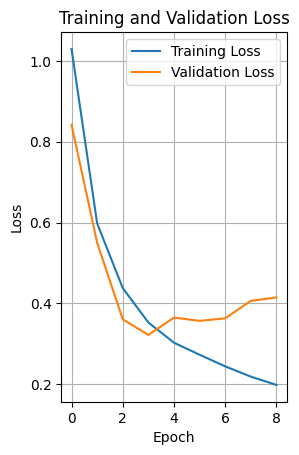

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
monitor='val_accuracy',
verbose=1,
patience=5,
mode='max',
restore_best_weights=True)
tf.random.set_seed(1234)
np.random.seed(1234)

# initialize model
model_tf = tf.keras.Sequential()

# add convolutional layer
model_tf.add(tf.keras.layers.Conv2D(
    filters=12,
    kernel_size=(4, 4),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    activation='relu',
    name='conv_1'
))

# add max pooling layer
model_tf.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

# add dropout layer
model_tf.add(tf.keras.layers.Dropout(rate=0.7))

# add a flattening layer
model_tf.add(tf.keras.layers.Flatten())

# add the classification layer (doing binary because of loss given)
model_tf.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# build and compile model
model_tf.build(input_shape=(None, 224, 224, 3))
model_tf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# print model_tf summary
model_tf.summary()

# train model_tf on (X_train, y_train) data
history = model_tf.fit(x=X_train, y=y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[early_stopping], batch_size = 32)

# plot loss curves
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# evaluate the accuracy of model_tf on (X_train, y_train) and (X_val, y_val)
train_loss, train_accuracy = model_tf.evaluate(X_train, y_train)
val_loss, val_accuracy = model_tf.evaluate(X_val, y_val)

print("Train Accuracy: ", train_accuracy)
print("Val Accuracy: ", val_accuracy)

How many parameters does your fine-tuned model have? 151,117 parameters

Comment on accuracy of the fine-tuned model on training vs. validation performance. Is there an improvement over the non-fine-tuned version?

There is a drastic improvement. The generalization is good, with the difference between training and validation still being less than 5%.  Here, the training and validation accuracies are both around 90%, which is a huge improvement from the previous 50%. Further, the validation accuracy is more than the training accuracy, which means the model performed better without dropped data (a good sign).

---
### Step 6: Evaluation

#### <span style="color:chocolate"> Exercise 7 (10 points) </span>

You will now use the test data to evaluate the performance (accuracy) of your fine-tuned model on unseen data. Does your model generalize well?

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
monitor='val_accuracy',
verbose=1,
patience=5,
mode='max',
restore_best_weights=True)
tf.random.set_seed(1234)
np.random.seed(1234)

# initialize model
model_tf = tf.keras.Sequential()

# add convolutional layer
model_tf.add(tf.keras.layers.Conv2D(
    filters=12,
    kernel_size=(4, 4),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    activation='relu',
    name='conv_1'
))

# add max pooling layer
model_tf.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

# add dropout layer
model_tf.add(tf.keras.layers.Dropout(rate=0.7))

# add a flattening layer
model_tf.add(tf.keras.layers.Flatten())

# add the classification layer (doing binary because of loss given)
model_tf.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# build and compile model
model_tf.build(input_shape=(None, 224, 224, 3))
model_tf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# train model_tf on (X_train, y_train) data
history = model_tf.fit(x=X_train, y=y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[early_stopping], batch_size = 32)

# evaluate the accuracy of model_tf on test data
test_loss, test_accuracy = model_tf.evaluate(X_test, y_test)
print("Test Accuracy: ", test_accuracy)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5253 - loss: 1.1380 - val_accuracy: 0.8438 - val_loss: 0.5523
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6845 - loss: 0.6072 - val_accuracy: 0.7500 - val_loss: 0.3943
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 779ms/step - accuracy: 0.8455 - loss: 0.4185 - val_accuracy: 0.9062 - val_loss: 0.3343
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8463 - loss: 0.3243 - val_accuracy: 0.9062 - val_loss: 0.3185
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 811ms/step - accuracy: 0.9021 - loss: 0.2948 - val_accuracy: 0.8750 - val_loss: 0.3224
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 950ms/step - accuracy: 0.9396 - loss: 0.2582 - val_accuracy: 0.8750 - val_loss: 0.3037
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 929ms/step - accuracy: 0.9281 - loss: 0.2252 - val_accuracy: 0.9062 - val_loss: 0.3318
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 773ms/step - accuracy: 0.9502 - loss: 0.2173 - val_accuracy: 0.8750 - val_loss: 0.3722


Does your model generalize well? Yes because the test accuracy is 0.84 and the training one was about 0.89. This is a 5% difference. Since they are close together, the model generalizes well.